## 第6章 ファクター・モデルの導入

### 6.1 ファクター構築の準備

#### 6.1.1 市場ポートフォリオの構築

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pandasのバージョンによっては，将来の仕様変更に関する警告が発せられるため，それを非表示に
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ch06_01: データの読み込み

monthly_data = pd.read_csv("ch05_output1.csv")
annual_data = pd.read_csv("ch05_output2.csv")

In [3]:
# ch06_02: 前年度の時価総額を追加

annual_data['lagged_ME'] = annual_data.groupby('firm_ID')['ME'].shift(1) 

In [4]:
# ch06_03: 市場ポートフォリオ作成のための保有比率の計算

annual_data['w_M'] = (
    annual_data['lagged_ME'] /
    annual_data.groupby('year')['lagged_ME'].transform('sum')
)

In [5]:
# ch06_04: 保有比率の欠損値を0で置き換え

# mask()メソッドは第一引数に条件を指定し，第二引数に置換する値を指定
annual_data['w_M'] = annual_data['w_M'].mask(
    (annual_data['year'] >= 2016) & (annual_data['w_M'].isna()), 0
)

In [6]:
# ch06_05: 各年度の保有比率の合計が1になっていることを確認

print(annual_data.groupby('year')['w_M'].sum())

## year
## 2015    0.0
## 2016    1.0
## 2017    1.0
## 2018    1.0
## 2019    1.0
## 2020    1.0
## Name: w_M, dtype: float64

year
2015    0.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
Name: w_M, dtype: float64


In [7]:
# ch06_06: 月次データに保有比率のデータを追加

monthly_data = monthly_data.merge(
    annual_data[['year', 'firm_ID', 'w_M']], 
    on=['year', 'firm_ID'], 
    how='outer'
)

In [8]:
# ch06_07: 市場ポートフォリオの月次リターンを計算

# month_IDが13以上のデータだけ抽出し，factor_dataというデータフレームを作成
factor_data = monthly_data[monthly_data['month_ID'] >= 13].copy().reset_index() 

factor_data = (
    factor_data.groupby('month_ID').apply(
        lambda x: pd.Series({  # 各Seriesに対して無名関数を適用
            'R_F': x['R_F'].iloc[0],  # R_Fについては各月の先頭行の値を抽出
            'R_M': (x['w_M'] * x['R']).sum(skipna=True)  # R_Mについては各銘柄の月次リターンの加重平均を計算
        })
    )
    .reset_index()  # インデックスをリセット
)

factor_data['R_Me'] = factor_data['R_M'] - factor_data['R_F']  # 月次超過リターンを計算

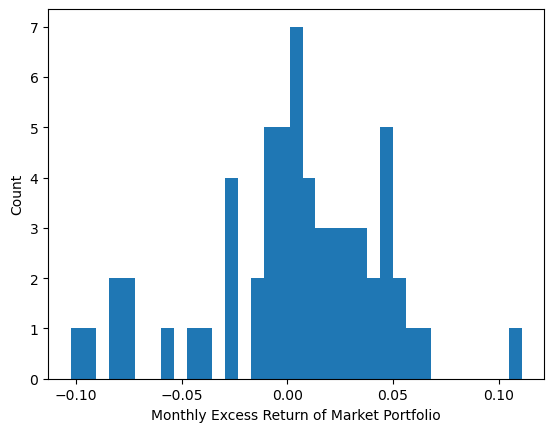

In [9]:
# ch06_08: 市場ポートフォリオの月次超過リターンをヒストグラムで可視化

plt.hist(factor_data['R_Me'], bins=35)  # Rでのアウトプットに近付けるため，bins引数はautoとせず，35に設定
plt.xlabel("Monthly Excess Return of Market Portfolio")
plt.ylabel("Count")
plt.show()

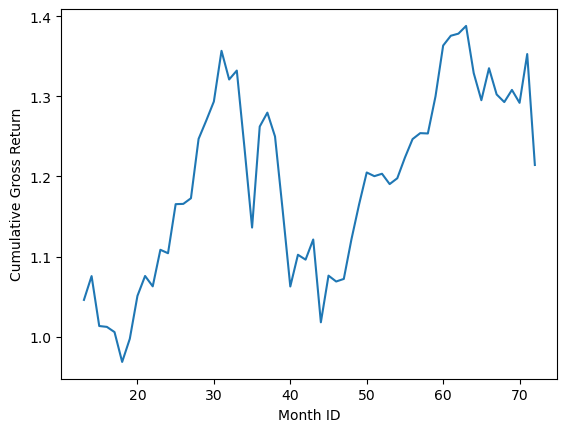

In [10]:
# ch06_09: 市場ポートフォリオの累積リターンの可視化 (1)

factor_data['gross_R_M'] = 1 + factor_data['R_M']  # ネット・リターンからグロス・リターンを計算
factor_data['cumulative_gross_R_M'] = factor_data['gross_R_M'].cumprod()  # グロス・リターンを累積

plt.plot(
    factor_data['month_ID'], 
    factor_data['cumulative_gross_R_M']
)
plt.xlabel('Month ID')
plt.ylabel('Cumulative Gross Return')
plt.show()

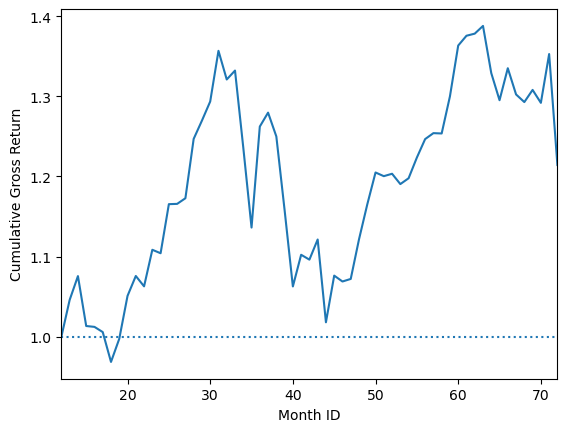

In [11]:
# ch06_10: 市場ポートフォリオの累積リターンの可視化 (2)

factor_data['gross_R_M'] = 1 + factor_data['R_M']
factor_data['cumulative_gross_R_M'] = factor_data['gross_R_M'].cumprod()

# 折れ線グラフの始点となるデータフレームstarting_pointを作成
starting_point = pd.DataFrame({"month_ID": [12], "cumulative_gross_R_M": [1]})  

# pandasのconcat()関数を使って始点のデータを追加
factor_data = pd.concat([starting_point, factor_data]).reset_index(drop=True)  

plt.plot(
    factor_data['month_ID'], 
    factor_data['cumulative_gross_R_M']
)
plt.axhline(y=1, linestyle='dotted')  # 元本の水準を点線で図示
plt.xlim(12, 72)  # month_IDの範囲を明示的に指定
# 実践上は，下限値・上限値を指定するのにfactor_data['month_ID'].min()というように関数やメソッドを利用するのが一般的
plt.xlabel('Month ID')
plt.ylabel('Cumulative Gross Return')
plt.show()

#### 6.1.2 ポートフォリオ・ソート

In [12]:
# ch06_11: 前年度末の時価総額に基づくポートフォリオ・ソート (1)

# 前年度末の時価総額が欠損値のものを削除（削除しないと，後に実行するqcut()関数でエラーが生じる）
annual_data = annual_data[annual_data['lagged_ME'].notna()].reset_index(drop=True)

# labels引数にFalseを指定することで，整数のインデックス (0から9)が十分位に割り当てられる
annual_data['ME_rank10'] = annual_data.groupby('year')['lagged_ME'].transform(
    lambda x: pd.qcut(x, 10, labels=False) + 1
)
# Rのntile()関数とPythonのqcut()関数では，サンプルを均等にグループ分けできない場合の処理の仕方が異なるので，
# 以下の一部のアウトプットでは，教科書のそれと微妙に異なるケースが出てくるので要注意．

annual_data['ME_rank10'] = annual_data['ME_rank10'].astype('category')  # ME_rank10をカテゴリ型に変換

In [13]:
# ch06_12: 各ポートフォリオに属する企業数を確認

print(annual_data.groupby(['year', 'ME_rank10']).size().reset_index(name='N'))

    year ME_rank10    N
0   2016         1  125
1   2016         2  124
2   2016         3  124
3   2016         4  124
4   2016         5  124
5   2016         6  124
6   2016         7  124
7   2016         8  124
8   2016         9  124
9   2016        10  124
10  2017         1  127
11  2017         2  127
12  2017         3  127
13  2017         4  127
14  2017         5  127
15  2017         6  127
16  2017         7  127
17  2017         8  127
18  2017         9  127
19  2017        10  127
20  2018         1  127
21  2018         2  127
22  2018         3  127
23  2018         4  126
24  2018         5  127
25  2018         6  127
26  2018         7  126
27  2018         8  127
28  2018         9  127
29  2018        10  127
30  2019         1  131
31  2019         2  130
32  2019         3  130
33  2019         4  131
34  2019         5  130
35  2019         6  130
36  2019         7  131
37  2019         8  130
38  2019         9  130
39  2019        10  131
40  2020        

In [14]:
# ch06_13: 前年度末の時価総額に基づくポートフォリオ・ソート (2)

ME_sorted_portfolio = (
    annual_data[['year', 'firm_ID', 'ME_rank10']]  # 年次データから追加したい情報を抽出
    .merge(monthly_data, on=['year', 'firm_ID'], how='outer')  # yearとfirm_IDをキーに月次データと結合
    .dropna()  # 欠損行を削除
    .groupby(['month_ID', 'ME_rank10'])['Re']  # month_IDとME_rank10に関してグループ化
    .mean()  # 各グループで月次超過リターンの平均値を計算
    .reset_index()
)

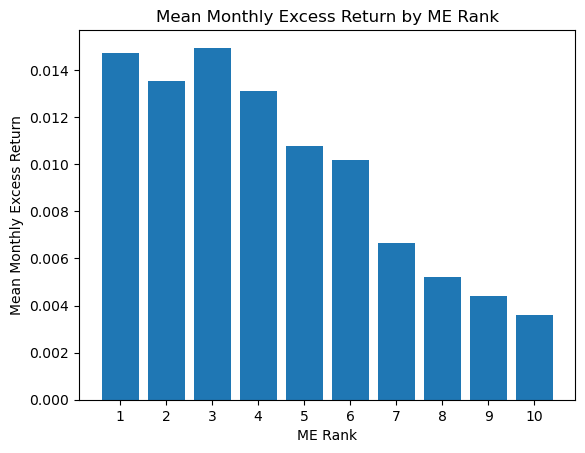

In [15]:
# ch06_14: 各ポートフォリオの平均超過リターンを可視化

ME_cross_sectional_return = (
    ME_sorted_portfolio
    .groupby('ME_rank10')['Re']
    .mean()
    .reset_index()
    .rename(columns={'Re': 'mean_Re'})
)

# matplotlibで棒グラフを作成
plt.bar(
    ME_cross_sectional_return['ME_rank10'], 
    ME_cross_sectional_return['mean_Re']
)
plt.xticks(ME_cross_sectional_return['ME_rank10'])  # x軸は1から10までの全てのラベルが表示されるようにする
plt.xlabel("ME Rank")
plt.ylabel("Mean Monthly Excess Return")
plt.title("Mean Monthly Excess Return by ME Rank")
plt.show()

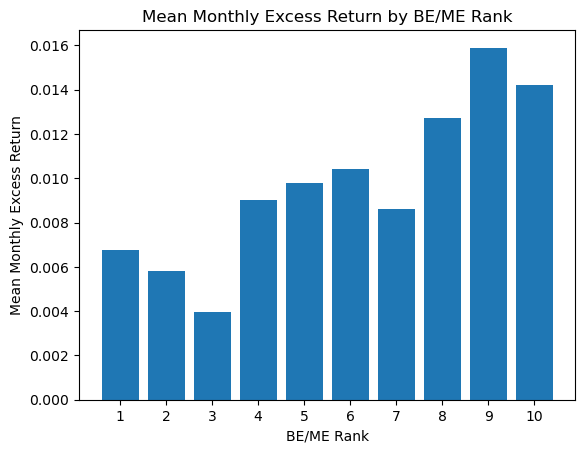

In [16]:
# ch06_15a: 簿価時価比率に基づくポートフォリオ・ソート（等加重の場合）

annual_data['lagged_BEME'] = annual_data['lagged_BE'] / annual_data['lagged_ME']

# 前年度末のBE/MEが欠損値のものを削除
annual_data = annual_data[annual_data['lagged_BEME'].notna()].reset_index(drop=True)

# 前年度末のBE/MEに基づいてポートフォリオ・ソート
annual_data['BEME_rank10'] = (
    annual_data.groupby('year')['lagged_BEME']
    .transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
)

# BEME_rank10列をカテゴリ型に変換
annual_data['BEME_rank10'] = annual_data['BEME_rank10'].astype('category') 

# ポートフォリオごとに保有比率として等加重を前提とした月次超過リターンを計算
BEME_sorted_portfolio = (
    annual_data[['year', 'firm_ID', 'BEME_rank10', 'lagged_ME']]
    .merge(monthly_data, on=['year', 'firm_ID'], how='outer')
    .dropna()
    .groupby(['month_ID', 'BEME_rank10'])['Re']
    .mean()
    .reset_index()
)

# 全期間にわたる各ポートフォリオの平均リターンを計算
BEME_cross_sectional_return = (
    BEME_sorted_portfolio.groupby('BEME_rank10')['Re']
    .mean()
    .reset_index(name='mean_Re')
)

# matplotlibで棒グラフを作成
plt.bar(
    BEME_cross_sectional_return['BEME_rank10'], 
    BEME_cross_sectional_return['mean_Re']
)
plt.xticks(BEME_cross_sectional_return['BEME_rank10']) 
plt.xlabel("BE/ME Rank")
plt.ylabel("Mean Monthly Excess Return")
plt.title("Mean Monthly Excess Return by BE/ME Rank")
plt.show()

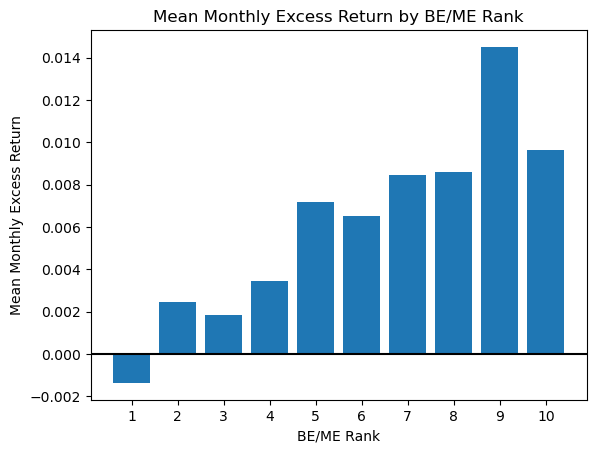

In [17]:
# ch06_15b: 簿価時価比率に基づくポートフォリオ・ソート（時価総額加重の場合）

BEME_sorted_portfolio = (
    annual_data[['year', 'firm_ID', 'BEME_rank10', 'lagged_ME']]
    .merge(monthly_data, on=['year', 'firm_ID'], how='outer')
    .dropna()
)

# 各銘柄の保有比率wを計算
BEME_sorted_portfolio['w'] = (
    BEME_sorted_portfolio['lagged_ME'] / 
    BEME_sorted_portfolio
    .groupby(['month_ID', 'BEME_rank10'])['lagged_ME']
    .transform('sum')
)

# ポートフォリオごとに保有比率として時価総額加重を前提とした月次超過リターンを計算
BEME_sorted_portfolio = (
    BEME_sorted_portfolio
    .groupby(['month_ID', 'BEME_rank10'])[['Re', 'w']]
    .apply(lambda x: (x['Re'] * x['w']).sum())
    .reset_index(name='Re')
)

# 全期間にわたる各ポートフォリオの平均リターンを計算
BEME_cross_sectional_return = (
    BEME_sorted_portfolio.groupby('BEME_rank10')['Re']
    .mean()
    .reset_index(name='mean_Re')
)

# matplotlibで棒グラフを作成
plt.bar(
    BEME_cross_sectional_return['BEME_rank10'], 
    BEME_cross_sectional_return['mean_Re']
)
plt.xticks(BEME_cross_sectional_return['BEME_rank10']) 
plt.xlabel("BE/ME Rank")
plt.ylabel("Mean Monthly Excess Return")
plt.title("Mean Monthly Excess Return by BE/ME Rank")
plt.axhline(y=0, color='black')
plt.show()

### 6.2 CAPMの実証的な検証

#### 6.2.2 時系列回帰

In [18]:
# ch06_16: 市場ポートフォリオの超過リターンを追加

ME_sorted_portfolio = ME_sorted_portfolio.merge(factor_data, on='month_ID') 

In [19]:
# ch06_17: 時系列回帰 (1)

import statsmodels.formula.api as smf  # statsmodelsからformula.apiモジュールを読み込み

ME_sorted_portfolio_data = ME_sorted_portfolio[ME_sorted_portfolio['ME_rank10'] == 1]

# 回帰結果をresultsに表示し，推定結果の概要を確認
results = smf.ols('Re ~ R_Me', data=ME_sorted_portfolio_data).fit()
print(results.summary())  # summary()メソッドを用いて，回帰結果の概要を表示

                            OLS Regression Results                            
Dep. Variable:                     Re   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     44.88
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           9.37e-09
Time:                        08:46:30   Log-Likelihood:                 124.05
No. Observations:                  60   AIC:                            -244.1
Df Residuals:                      58   BIC:                            -239.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0121      0.004      3.002      0.0

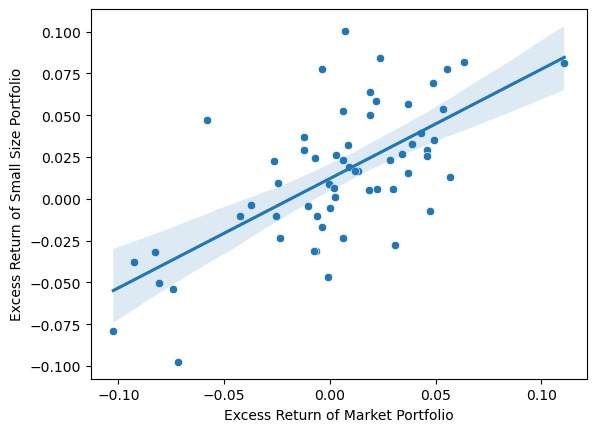

In [20]:
# ch06_18: 時系列回帰 (2)

sns.scatterplot(
    x='R_Me', 
    y='Re', 
    data=ME_sorted_portfolio_data
)
sns.regplot(
    x='R_Me',
    y='Re',
    data=ME_sorted_portfolio_data,
    scatter=False
)
plt.xlabel("Excess Return of Market Portfolio")
plt.ylabel("Excess Return of Small Size Portfolio")
plt.show()

In [21]:
# ch06_19: CAPMの実証的な検証 (1)

# 推定結果を保存するために空のリストを準備
CAPM_results = []

for i in range(1, 11): 
    # 第i十分位のデータを抽出し、ME_sorted_portfolio_dataとして保存
    ME_sorted_portfolio_data = ME_sorted_portfolio[ME_sorted_portfolio['ME_rank10'] == i]
    
    # ポートフォリオごとの推定結果をデータフレームresultsに格納
    results = smf.ols('Re ~ R_Me', data=ME_sorted_portfolio_data).fit()
    
    # 回帰結果をデータフレームdfとして保存
    df = results.summary2().tables[1]
    df['ME_rank10'] = i
    df['ME_rank10'] = df['ME_rank10'].astype('category')

    # 回帰結果を保存したdfをリストに代入
    CAPM_results.append(df)  

In [22]:
# ch06_20: CAPMの実証的な検証 (2)

# pandasのconcat()関数を使ってリストに入っているデータフレームを一つのデータフレームに統合
binded_CAPM_results = pd.concat(CAPM_results) 

# ME_rank10列を先頭列に移動
binded_CAPM_results = binded_CAPM_results[
    ['ME_rank10'] + [col for col in binded_CAPM_results.columns if col != 'ME_rank10']
]

**コードch06_21とコードch06_22は，R言語特有のものであるため割愛**

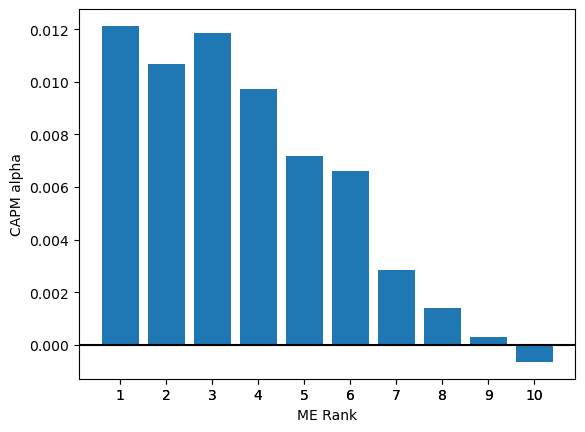

In [23]:
# ch06_23: CAPMアルファの可視化

plt.bar(
    binded_CAPM_results.loc["Intercept", 'ME_rank10'],
    binded_CAPM_results.loc["Intercept", 'Coef.']
)
plt.xticks(binded_CAPM_results['ME_rank10'])
plt.xlabel('ME Rank')
plt.ylabel('CAPM alpha')
plt.axhline(y=0, color='black')
plt.show()

In [24]:
# ch06_24: CAPMアルファの統計的な有意性を評価

CAPM_alpha_results = (
    binded_CAPM_results
    .loc["Intercept"]
    .rename(columns={'Coef.': 'CAPM_alpha', 'P>|t|': 'p_value'})
    .assign(significance=pd.cut(
        binded_CAPM_results.loc["Intercept", 'P>|t|'],
        bins=[0, 0.01, 0.05, 0.1, 1],
        labels=['***', '**', '*', ''],
        include_lowest=True
    ))
    .reset_index()[['ME_rank10', 'CAPM_alpha', 'p_value', 'significance']]
)

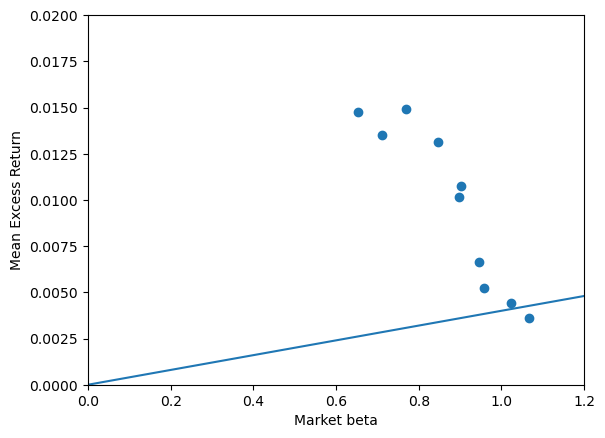

In [25]:
# ch06_25: 証券市場線の推定

# R_Meの係数に関する推定結果のみを抽出、推定値をestimateからCAPM_betaに名称変更
CAPM_beta_results = (
    binded_CAPM_results.loc["R_Me"]
    .rename(columns={'Coef.': 'CAPM_beta'})[['ME_rank10', 'CAPM_beta']]
)

# 超過リターンのデータと結合
ME_cross_sectional_return = ME_cross_sectional_return.merge(CAPM_beta_results, on='ME_rank10')

# 市場ポートフォリオの実現超過リターンにより証券市場線の傾きを推定
mean_R_Me = factor_data['R_Me'].mean()

# マーケット・ベータと平均超過リターンの散布図を描画
plt.scatter(
    ME_cross_sectional_return['CAPM_beta'], 
    ME_cross_sectional_return['mean_Re']
)
# 傾きがmean_R_Meである直線を描画
plt.plot(
    [0, 1.2], 
    [0, 1.2 * mean_R_Me]
) 
plt.xlim(0, 1.2)
plt.ylim(0, 0.02)
plt.xlabel('Market beta')
plt.ylabel('Mean Excess Return')
plt.show()

In [26]:
# ch06_26: 前年度の時価総額に基づくランク付け

# 年度ごとにランク付け
annual_data['ME_rank2'] = (
    annual_data.groupby('year')['lagged_ME']
    .transform(lambda x: pd.qcut(x, 2, labels=False) + 1)
)
annual_data['ME_rank2'] = annual_data['ME_rank2'].astype('category')

In [27]:
# ch06_27: 簿価時価比率に基づくランク付け (1)

# 年度ごとに簿価時価比率のパーセンタイル順位を計算
annual_data['BEME_percent_rank'] = (
    annual_data.groupby('year')['lagged_BEME']
    .rank(pct=True)
)

In [28]:
# ch06_28: 簿価時価比率に基づくランク付け (2)

# 年度ごとに簿価時価比率のパーセンタイル順位を計算
annual_data['BEME_percent_rank'] = (
    annual_data.groupby('year')['lagged_BEME']
    .rank(pct=True)
)

# BEME_percent_rankの値に応じて1から3までBEME_rank3の値を定義
annual_data['BEME_rank3'] = pd.cut(
    annual_data['BEME_percent_rank'],
    bins=[0, 0.3, 0.7, 1],
    labels=['1', '2', '3'],
    include_lowest=True
)

In [29]:
# ch06_29: 6 Size-BE/MEポートフォリオへの分類 (1)

annual_data['FF_portfolio_type'] = (
    annual_data['ME_rank2'].astype(str) + '.' + annual_data['BEME_rank3'].astype(str)
)
annual_data['FF_portfolio_type'] = annual_data['FF_portfolio_type'].astype('category')

In [30]:
# ch06_30: 6 Size-BE/MEポートフォリオへの分類 (2)

# 各ポートフォリオ・タイプに名前を付してrecode_dictとして定義
recode_dict = {
    "1.1": "SL",
    "2.1": "BL",
    "1.2": "SN",
    "2.2": "BN",
    "1.3": "SH",
    "2.3": "BH"
}

annual_data['FF_portfolio_type'] = annual_data['FF_portfolio_type'].replace(recode_dict)

In [31]:
# ch06_31: 6 Size-BE/MEポートフォリオへの分類 (3)

portfolio_characteristics = (
    annual_data.groupby('FF_portfolio_type')
    .agg(
        mean_BEME=('lagged_BEME', 'mean'),
        mean_ME=('lagged_ME', 'mean'),
        N_year=('year', 'nunique'),
        N_stocks=('firm_ID', 'count')
    )
    .reset_index()
)

portfolio_characteristics['mean_N_stocks'] = (
    portfolio_characteristics['N_stocks'] / portfolio_characteristics['N_year']
)

In [32]:
# ch06_32: 6 Size-BE/MEポートフォリオの構築 (1)

annual_data['w'] = annual_data.groupby(['year', 'FF_portfolio_type'])['lagged_ME'].transform(
    lambda x: x / x.sum()
)

In [33]:
# ch06_33: 6 Size-BE/MEポートフォリオの構築 (2)

# 列の選択
FF_portfolio = annual_data[['year', 'firm_ID', 'FF_portfolio_type', 'ME_rank2', 'BEME_rank3', 'w']]

# 今までに準備したデータと月次データを結合
FF_portfolio = FF_portfolio.merge(monthly_data, on=['year', 'firm_ID'], how='outer')

# ME_rank2やBEME_rank3が欠損値なら削除
FF_portfolio = FF_portfolio = FF_portfolio.dropna(subset=['ME_rank2', 'BEME_rank3']) 

# month_IDとFF_portfolio_typeでグループ化して月次リターンを計算
FF_portfolio = (
    FF_portfolio.groupby(['month_ID', 'FF_portfolio_type'])
    .apply(lambda x: pd.Series({
        'ME_rank2': x['ME_rank2'].iloc[0],
        'BEME_rank3': x['BEME_rank3'].iloc[0],
        'R': (x['w'] * x['R']).sum(),
        'R_F': x['R_F'].iloc[0]
    }))
    .reset_index()
)

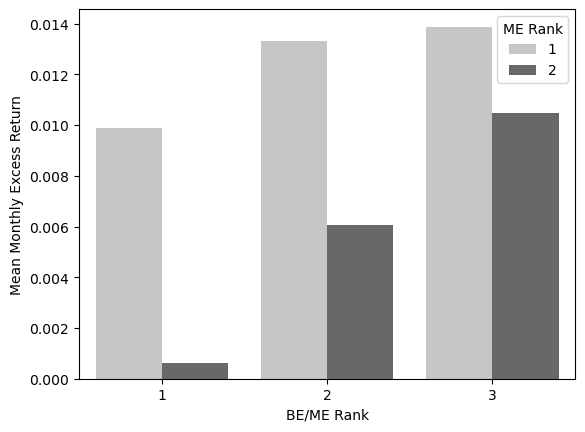

In [34]:
# ch06_34: 6 Size-BE/MEポートフォリオのリターンの可視化 (1)

# 各ポートフォリオの月次超過リターンReを計算
FF_portfolio['Re'] = FF_portfolio['R'] - FF_portfolio['R_F']

# ポートフォリオごとに平均リターンを計算
FF_portfolio_mean_return = (
    FF_portfolio.groupby('FF_portfolio_type')
    .agg(
        ME_rank2=('ME_rank2', 'first'),
        BEME_rank3=('BEME_rank3', 'first'),
        mean_Re=('Re', 'mean')
    )
    .reset_index()
)

# 上記の集約作業によって，ME_rank2列とBEME_rank3列は型変換がなされているので，カテゴリ型へと再変換
FF_portfolio_mean_return['ME_rank2'] = FF_portfolio_mean_return['ME_rank2'].astype('category')
FF_portfolio_mean_return['BEME_rank3'] = FF_portfolio_mean_return['BEME_rank3'].astype('category')

# seabornを使って棒グラフの描画
ax = sns.barplot(
    data=FF_portfolio_mean_return,
    x='BEME_rank3',
    y='mean_Re',
    hue='ME_rank2',
    palette='Greys',
    dodge=True  # dodge引数は，geom_col()関数のposition引数に相当
)

# 軸ラベルとタイトルの設定
plt.xlabel("BE/ME Rank")
plt.ylabel("Mean Monthly Excess Return")
ax.legend(title='ME Rank')

plt.show()

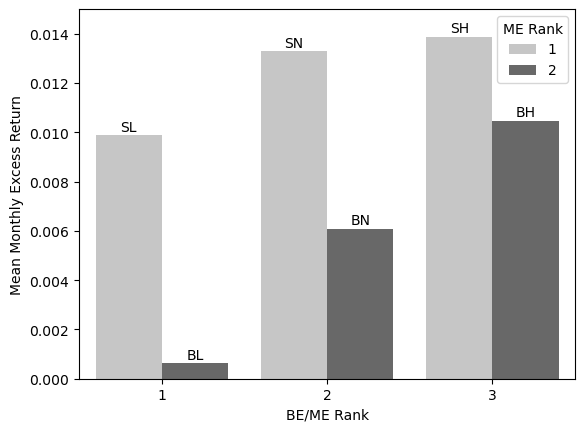

In [35]:
# ch06_35: 6 Size-BE/MEポートフォリオのリターンの可視化 (2)

# seabornを使って棒グラフの描画
ax = sns.barplot(
    data=FF_portfolio_mean_return,
    x='BEME_rank3',
    y='mean_Re',
    hue='ME_rank2',
    palette='Greys',
    dodge=True  
)

# 軸ラベルとタイトルの設定
plt.xlabel("BE/ME Rank")
plt.ylabel("Mean Monthly Excess Return")
ax.legend(title='ME Rank')

# 棒グラフに各ポートフォリオの名前を追加
for p, ff_type in zip(ax.patches, FF_portfolio_mean_return['FF_portfolio_type']):
    # ax.annotate()関数を利用し，グラフ上の特定の位置にテキストを描画
    ax.annotate(ff_type,  # 追加するテキストを指定
                (p.get_x() + p.get_width() / 2., p.get_height()),  # テキストを描画する位置を指定
                ha='center', va='bottom',  # ha引数で水平方向の配置，va引数で垂直方向の配置を指定
                xytext=(0, 1), textcoords='offset points')  # テキストの位置を微調整
    
# y軸の範囲の設定
plt.ylim(0, 0.015)

plt.show()

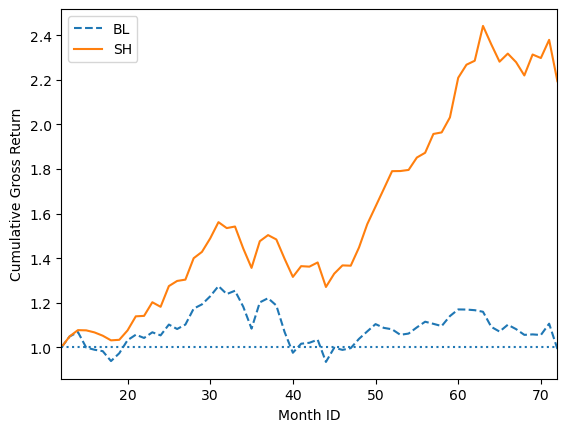

In [36]:
# ch06_36: 6 Size-BE/MEポートフォリオのリターンの可視化 (3)

# 起点をinitial_pointとして設定
initial_point = pd.DataFrame({
    'month_ID': [12, 12],
    'cumulative_gross_R': [1, 1],
    'FF_portfolio_type': ['BL', 'SH']
})

# ポートフォリオごとにグロス・リターンを累積
FF_portfolio_cumulative_return = (
    FF_portfolio
    .groupby('FF_portfolio_type')
    .apply(lambda df: df.assign(cumulative_gross_R=(1 + df['R']).cumprod()))
    .reset_index(drop=True)
    .query("FF_portfolio_type in ['BL', 'SH']")
    [['month_ID', 'cumulative_gross_R', 'FF_portfolio_type']]
)

# initial_pointを第一行に挿入
FF_portfolio_cumulative_return = pd.concat(
    [initial_point, FF_portfolio_cumulative_return], 
    ignore_index=True
)

# ポートフォリオごとにデータフレームを作成
portfolio_BL = FF_portfolio_cumulative_return[FF_portfolio_cumulative_return['FF_portfolio_type'] == 'BL']
portfolio_SH = FF_portfolio_cumulative_return[FF_portfolio_cumulative_return['FF_portfolio_type'] == 'SH']

# 二つのポートフォリオの累積リターンを描画
plt.plot(portfolio_BL['month_ID'], portfolio_BL['cumulative_gross_R'], label='BL', linestyle='dashed')
plt.plot(portfolio_SH['month_ID'], portfolio_SH['cumulative_gross_R'], label='SH', linestyle='solid')

# その他のグラフ設定
plt.axhline(y=1, linestyle='dotted')
plt.xlabel("Month ID")
plt.ylabel("Cumulative Gross Return")
plt.xlim(12, 72)  # month_IDの範囲を明示的に指定
plt.legend()
plt.show()

In [37]:
# ch06_37: SMBとHMLの構築 (1)

FF_portfolio = (
    FF_portfolio
    .pivot_table(
        index='month_ID', 
        columns='FF_portfolio_type',
        values='R'
    )
    .reset_index()
)

In [38]:
# ch06_38: SMBとHMLの構築 (2)

# SMBとHMLの計算
FF_portfolio['SMB'] = (
    (FF_portfolio['SH'] + FF_portfolio['SN'] + FF_portfolio['SL']) / 3 -
    (FF_portfolio['BH'] + FF_portfolio['BN'] + FF_portfolio['BL']) / 3
)

FF_portfolio['HML'] = (
    (FF_portfolio['SH'] + FF_portfolio['BH']) / 2 -
    (FF_portfolio['SL'] + FF_portfolio['BL']) / 2
)

# 必要な列だけ選択
FF_portfolio = FF_portfolio[['month_ID', 'SMB', 'HML']]

# factor_dataに結合
factor_data = factor_data.merge(FF_portfolio, how='outer', on='month_ID')
factor_data = factor_data[['month_ID', 'R_F', 'R_M', 'R_Me', 'SMB', 'HML']].dropna().reset_index(drop=True)

In [39]:
# ch06_39: FF3モデルの推定

ME_sorted_portfolio = ME_sorted_portfolio.drop(columns=['R_Me', 'R_M', 'R_F'])

# ファクター・データと結合
ME_sorted_portfolio = ME_sorted_portfolio.merge(factor_data, how='outer', on='month_ID')

# 推定結果を保存するために空のリストを準備
FF3_results = [] 

for i in sorted(ME_sorted_portfolio['ME_rank10'].unique()):
    # 第i十分位のデータを抽出し，ME_sorted_portfolio_dataとして保存
    ME_sorted_portfolio_data = ME_sorted_portfolio[ME_sorted_portfolio['ME_rank10'] == i]
    # ポートフォリオごとの推定結果をデータフレームresultsに格納
    results = smf.ols('Re ~ R_Me + SMB + HML', data=ME_sorted_portfolio_data).fit()
    
    # 回帰結果をデータフレームdfとして保存
    df = results.summary2().tables[1]
    df['ME_rank10'] = i
    df['ME_rank10'] = df['ME_rank10'].astype('category')

    FF3_results.append(df)  # 回帰結果を保存したdfをリストに代入

# pandasのconcat()関数を使ってリストに入っているデータフレームを一つのデータフレームに統合
binded_FF3_results = pd.concat(FF3_results) 
binded_FF3_results = binded_FF3_results[
    ['ME_rank10'] + [col for col in binded_FF3_results.columns if col != 'ME_rank10']
]

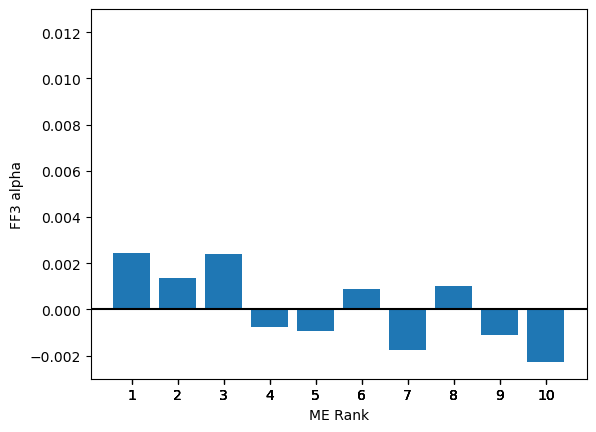

In [40]:
# ch06_40: FF3アルファの可視化

plt.bar(
    binded_FF3_results.loc["Intercept", 'ME_rank10'], 
    binded_FF3_results.loc["Intercept", 'Coef.']
)
plt.xticks(binded_FF3_results['ME_rank10']) 
plt.ylim(-0.003, 0.013)
plt.xlabel('ME Rank')
plt.ylabel('FF3 alpha')
plt.axhline(y=0, color='black')
plt.show()

In [41]:
# ch06_41: FF3アルファの統計的な有意性を評価

FF3_alpha_results = (
    binded_FF3_results.loc["Intercept"]
    .rename(columns={'Coef.': 'FF3_alpha', 'P>|t|': 'p_value'})
    .assign(
        significance=pd.cut(
            binded_FF3_results.loc["Intercept", 'P>|t|'],
            bins=[0, 0.01, 0.05, 0.1, 1],
            labels=['***', '**', '*', ''],
            include_lowest=True
        )
    )
    .reset_index()[['ME_rank10', 'FF3_alpha', 'p_value', 'significance']]
)

**データフレームfactor_dataはコードch06_11に記載の理由によりRとPythonとで微妙に異なるため，コードch06_42のデータ保存は割愛**

In [42]:
# 以上のコードについて，動作確認をした実行環境の表示
# 本セルは，実行環境の確認のためであり，無視してもらっても構わない
import session_info
session_info.show(dependencies=False)